# Risk Analysis

This notebook constructs a **spatial–temporal risk index** for CitiBike stations by combining:

- **NYPD collision data** (crash severity, timestamp, location)
- **CitiBike trip data** (station locations, departures/exposure)

Our goals:

1. Warn users when starting trips from **high-risk stations at specific times**
2. Provide **insurers** with a credible expected-severity-per-trip model
3. Identify **infrastructure hotspots** for NYC DOT

We compute risk from:

- **Hazard** (sum of crash severity near the station)
- **Exposure** (number of CitiBike departures)
- **Empirical Bayes smoothing** (stabilizes low-volume estimates)

The analysis proceeds in four levels:

1. Station-level risk  
2. Time-of-day risk  
3. Station × time-of-day risk  
4. High-risk maps + strategic insights

In [ ]:
# Imports & Helper Functions
import pandas as pd
import numpy as np
import duckdb
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

plt.style.use("seaborn-v0_8")
sns.set_context("notebook")

# Global constants
EPS = 1e-6
EARTH_RADIUS_M = 6_371_000
MAX_DIST_M = 300   # collision → station matching
C = 200            # EB credibility constant

# Time-of-day categories
def time_of_day(h):
    if 5 <= h < 10: return "morning"
    if 10 <= h < 16: return "midday"
    if 16 <= h < 20: return "evening"
    if 20 <= h < 24: return "late_evening"
    return "night"

# Empirical Bayes smoother
def eb_smooth(H, E, mu_global, C=C):
    lam = E / (E + C)
    R_raw = H / (E + EPS)
    R_eb = lam * R_raw + (1 - lam) * mu_global
    return R_raw, R_eb, lam

In [ ]:
# Load Collision Data
COLLISION_PATH = "../data/processed/cleaned_collision_data.csv"

collision = pd.read_csv(COLLISION_PATH, parse_dates=["CRASH DATETIME"])
collision = collision.dropna(subset=["LATITUDE","LONGITUDE","CRASH DATETIME"])

collision["weekday"] = collision["CRASH DATETIME"].dt.day_name()
collision["hour"] = collision["CRASH DATETIME"].dt.hour
collision["tod"] = collision["hour"].apply(time_of_day)


### Compute Crash Severity
We define severity:

$$
S_i = (1 + W_I \cdot \text{injured}_i + W_K \cdot \text{killed}_i)
      \cdot (\alpha + (1-\alpha)\cdot \text{cyclist}_i)
$$

We choose:
- Cyclist crashes: ×1  
- Non-cyclist crashes: ×0.1  
- Injuries: +5  
- Fatalities: +20  

In [50]:
W_I = 5
W_K = 20
alpha = 0.1

collision["CYCLIST_INVOLVED"] = collision["CYCLIST_INVOLVED"].fillna(0).astype(int)
collision["NUMBER OF PERSONS INJURED"] = collision["NUMBER OF PERSONS INJURED"].fillna(0)
collision["NUMBER OF PERSONS KILLED"] = collision["NUMBER OF PERSONS KILLED"].fillna(0)

base_severity = (
    1
    + W_I * collision["NUMBER OF PERSONS INJURED"]
    + W_K * collision["NUMBER OF PERSONS KILLED"]
)

collision["severity"] = (
    collision["CYCLIST_INVOLVED"] * base_severity
    + alpha * (1 - collision["CYCLIST_INVOLVED"]) * base_severity
)


In [ ]:
# Build Station Table
DATA_PATH = "../data/processed/citibike/*/*/data.parquet"
con = duckdb.connect()

stations = con.execute(
    """
    WITH trips AS (
        SELECT
            start_station_id, start_station_name, start_lat, start_lng,
            end_station_id,   end_station_name,   end_lat,   end_lng
        FROM read_parquet($path)
    ),
    unioned AS (
        SELECT start_station_id AS station_id, start_station_name AS station_name,
               start_lat AS lat, start_lng AS lon
        FROM trips WHERE start_station_id IS NOT NULL

        UNION

        SELECT end_station_id, end_station_name, end_lat, end_lng
        FROM trips WHERE end_station_id IS NOT NULL
    )
    SELECT DISTINCT CAST(station_id AS VARCHAR) AS station_id,
                    station_name,
                    ROUND(lat::DOUBLE, 5) AS lat,
                    ROUND(lon::DOUBLE, 5) AS lon
    FROM unioned
    ORDER BY station_id
    """,
    {"path": DATA_PATH},
).df()

stations = stations.dropna(subset=["lat","lon"])


In [ ]:
# Match Collisions → Stations (≤300 m)
station_coords = np.deg2rad(stations[["lat","lon"]].values)
tree = BallTree(station_coords, metric="haversine")

collision_coords = np.deg2rad(collision[["LATITUDE","LONGITUDE"]].values)
dist_rad, idx = tree.query(collision_coords, k=1)
dist_m = dist_rad.flatten() * EARTH_RADIUS_M

collision["station_id"] = np.where(dist_m <= MAX_DIST_M,
                                   stations.iloc[idx.flatten()]["station_id"].values,
                                   np.nan)

collision = collision.dropna(subset=["station_id"])


# Risk Analysis

We combine CitiBike trip data with NYPD collision records to quantify safety risks around CitiBike stations. Our goals are to  
(1) warn users when renting from high-risk stations,  
(2) show how the two datasets jointly inform insurers about expected loss, and  
(3) identify hazardous areas where CitiBike can advocate for safety improvements.

We measure **risk** as the *expected crash severity per CitiBike trip* at station $j$ and time bucket $b$ (weekday or time-of-day). This relies on:

- **Hazard**: total crash severity near the station,
  $$
  H_{j,b} = \sum_{i \in (j,b)} S_i ,
  $$
- **Exposure**: number of trips starting at that station/time, $E_{j,b}$.

The raw risk is  
$$
R_{j,b} = \frac{H_{j,b}}{E_{j,b} + \epsilon}.
$$

Because exposure varies widely, $R_{j,b}$ can be unstable when $E_{j,b}$ is small. We therefore apply **Empirical Bayes smoothing**, shrinking low-exposure estimates toward the global mean risk per trip $\mu$:
$$
R^{\text{eb}}_{j,b}
= \lambda_{j,b} R_{j,b} + (1-\lambda_{j,b})\mu,
\qquad 
\lambda_{j,b} = \frac{E_{j,b}}{E_{j,b}+C}.
$$
This produces stable, interpretable estimates while preserving genuine differences where exposure is large.

---

### Crash Severity and Hazard

Each crash receives a severity score $S_i$ reflecting cyclist involvement, injuries, and fatalities:

$$
S_i
=
\bigl(1 + W_I\,\text{injured}_i + W_K\,\text{killed}_i\bigr)
\bigl(\alpha + (1-\alpha)\,\text{cyclist}_i\bigr),
$$

where $\alpha<1$ down-weights non-cyclist crashes and $W_K > W_I$ ensures fatalities count more than injuries. Using $\alpha=0.1$, $W_I=5$, and $W_K=20$ yields a severity measure that strongly emphasizes crashes most relevant to CitiBike users.

Hazard for station $j$ and time $b$ is then

$$
H_{j,b} = \sum_{i \in (j,b)} S_i,
$$

capturing both general traffic danger and the disproportionate impact of cyclist-involved and severe crashes.


In [16]:
import pandas as pd
import numpy as np
import duckdb
from sklearn.neighbors import BallTree

# ---------------------------------------------------------------------
# Paths and constants
# ---------------------------------------------------------------------
DATA_PATH = "../data/processed/citibike/*/*/data.parquet"
COLLISION_PATH = "../data/processed/cleaned_collision_data.csv"

MAX_DIST_M = 300            
EARTH_RADIUS_M = 6_371_000  
EPS = 1e-6                  

# Severity weights
W_I = 5.0   
W_K = 20.0  
alpha = 0.1

# ---------------------------------------------------------------------
# Helper: time-of-day buckets
# ---------------------------------------------------------------------
def time_of_day(hour: int) -> str:
    if 5 <= hour < 10:
        return "morning"
    elif 10 <= hour < 16:
        return "midday"
    elif 16 <= hour < 20:
        return "evening"
    elif 20 <= hour < 24:
        return "late_evening"
    else:
        return "night"

# ---------------------------------------------------------------------
# 1. Load collision data and compute severity
# ---------------------------------------------------------------------
collision = pd.read_csv(COLLISION_PATH, parse_dates=["CRASH DATETIME"])
collision = collision.dropna(subset=["LATITUDE", "LONGITUDE", "CRASH DATETIME"])

collision["CYCLIST_INVOLVED"] = collision["CYCLIST_INVOLVED"].fillna(0).astype(int)
collision["NUMBER OF PERSONS INJURED"] = collision["NUMBER OF PERSONS INJURED"].fillna(0)
collision["NUMBER OF PERSONS KILLED"] = collision["NUMBER OF PERSONS KILLED"].fillna(0)
# Compute severity score

collision["severity"] = (
    collision["CYCLIST_INVOLVED"] * (1 + W_I * collision["NUMBER OF PERSONS INJURED"] + W_K * collision["NUMBER OF PERSONS KILLED"]) + 
    alpha * (1 - collision["CYCLIST_INVOLVED"]) * (1 + W_I * collision["NUMBER OF PERSONS INJURED"] + W_K * collision["NUMBER OF PERSONS KILLED"])
)

# ---------------------------------------------------------------------
# 2. Build station table (station_id, station_name, lat, lon)
# ---------------------------------------------------------------------
con = duckdb.connect()

stations = con.execute(
    """
    WITH trips AS (
        SELECT
            start_station_id,
            start_station_name,
            start_lat, start_lng,
            end_station_id,
            end_station_name,
            end_lat, end_lng
        FROM read_parquet($data_path)
    ),
    stations_union AS (
        SELECT
            start_station_id AS station_id,
            start_station_name AS station_name,
            start_lat AS lat,
            start_lng AS lon
        FROM trips
        WHERE start_station_id IS NOT NULL

        UNION

        SELECT
            end_station_id AS station_id,
            end_station_name AS station_name,
            end_lat AS lat,
            end_lng AS lon
        FROM trips
        WHERE end_station_id IS NOT NULL
    )
    SELECT DISTINCT
        CAST(station_id AS VARCHAR) AS station_id,
        station_name,
        ROUND(lat::DOUBLE, 5) AS lat,
        ROUND(lon::DOUBLE, 5) AS lon
    FROM stations_union
    ORDER BY station_id
    """,
    {"data_path": DATA_PATH},
).df()

stations = stations.dropna(subset=["lat", "lon"])

# ---------------------------------------------------------------------
# 3. Assign each collision to nearest station
# ---------------------------------------------------------------------
station_coords_rad = np.deg2rad(stations[["lat", "lon"]].values)
tree = BallTree(station_coords_rad, metric="haversine")

collision_coords_rad = np.deg2rad(collision[["LATITUDE", "LONGITUDE"]].values)
dist_rad, idx = tree.query(collision_coords_rad, k=1)
dist_m = dist_rad.flatten() * EARTH_RADIUS_M

nearest_station_ids = stations.iloc[idx.flatten()]["station_id"].values
collision["station_id"] = np.where(dist_m <= MAX_DIST_M, nearest_station_ids, np.nan)
collision = collision.dropna(subset=["station_id"])
collision["station_id"] = collision["station_id"].astype(str)

# ---------------------------------------------------------------------
# 4. Add time buckets + aggregate hazard H
# ---------------------------------------------------------------------
collision["weekday"] = collision["CRASH DATETIME"].dt.day_name()
collision["hour"] = collision["CRASH DATETIME"].dt.hour
collision["tod"] = collision["hour"].apply(time_of_day)

hazard = (
    collision.groupby(["station_id", "weekday", "tod"], as_index=False)["severity"]
    .sum()
    .rename(columns={"severity": "H"})
)

# ---------------------------------------------------------------------
# 5. Compute exposure E with DuckDB (station × weekday × tod)
# ---------------------------------------------------------------------
exposure = con.execute(
    """
    WITH trips AS (
        SELECT
            CAST(start_station_id AS VARCHAR) AS station_id,
            started_at
        FROM read_parquet($data_path)
        WHERE start_station_id IS NOT NULL
    ),
    trips_buckets AS (
        SELECT
            station_id,
            started_at,
            strftime(started_at, '%A') AS weekday,
            CASE
                WHEN EXTRACT(hour FROM started_at) BETWEEN 5 AND 9 THEN 'morning'
                WHEN EXTRACT(hour FROM started_at) BETWEEN 10 AND 15 THEN 'midday'
                WHEN EXTRACT(hour FROM started_at) BETWEEN 16 AND 19 THEN 'evening'
                WHEN EXTRACT(hour FROM started_at) BETWEEN 20 AND 23 THEN 'late_evening'
                ELSE 'night'
            END AS tod
        FROM trips
    )
    SELECT
        station_id,
        weekday,
        tod,
        COUNT(*) AS E
    FROM trips_buckets
    GROUP BY station_id, weekday, tod
    """,
    {"data_path": DATA_PATH},
).df()

# ---------------------------------------------------------------------
# 6. Merge hazard + exposure → compute risk
# ---------------------------------------------------------------------
risk_panel = pd.merge(
    exposure,
    hazard,
    on=["station_id", "weekday", "tod"],
    how="outer"
)

risk_panel["E"] = risk_panel["E"].fillna(0).astype(float)
risk_panel["H"] = risk_panel["H"].fillna(0).astype(float)

# Raw risk R_{j,b} = H_{j,b} / E_{j,b}
risk_panel["R"] = risk_panel["H"] / (risk_panel["E"] + EPS)

# Global mean risk per trip: μ = (∑ H) / (∑ E)
mu = risk_panel["H"].sum() / risk_panel["E"].sum()

# Credibility parameter C
C = 200.0  # as we used when you got the nice R_eb distribution

# λ_{j,b} = E_{j,b} / (E_{j,b} + C)
risk_panel["lambda"] = risk_panel["E"] / (risk_panel["E"] + C)

# EB-smoothed risk R^{eb}_{j,b} = λ R + (1-λ) μ
risk_panel["R_eb"] = risk_panel["lambda"] * risk_panel["R"] + (1 - risk_panel["lambda"]) * mu

# ---------------------------------------------------------------------
# 7. Merge station_name + lat + lon
# ---------------------------------------------------------------------
risk_panel = pd.merge(
    risk_panel,
    stations[["station_id", "station_name", "lat", "lon"]],
    on="station_id",
    how="left"
)

# Reorder columns
risk_panel = risk_panel[
    ["station_id", "station_name", "lat", "lon", "weekday", "tod", "E", "H", "R", "R_eb"]
]

risk_panel = risk_panel.sort_values(["station_id", "weekday", "tod"]).reset_index(drop=True)

risk_panel.head()


,station_id,station_name,lat,lon,weekday,tod,E,H,R,R_eb
0,1234.56,Morgan HCT Charging,40.70895,-73.93278,Friday,evening,18.0,0.0,0.000000,0.000917
1,1234.56,Morgan HCT Charging,40.70895,-73.93278,Friday,late_evening,35.0,0.1,0.002857,0.001276
2,1234.56,Morgan HCT Charging,40.70895,-73.93278,Friday,midday,38.0,0.1,0.002632,0.001260
3,1234.56,Morgan HCT Charging,40.70895,-73.93278,Friday,morning,19.0,0.0,0.000000,0.000913
4,1234.56,Morgan HCT Charging,40.70895,-73.93278,Friday,night,6.0,0.0,0.000000,0.000970


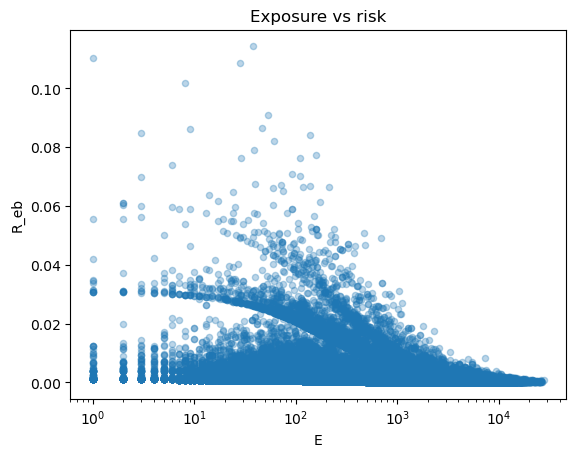

In [41]:
risk_panel.plot.scatter(x="E", y="R_eb", alpha=0.3)
plt.xscale("log")
plt.title("Exposure vs risk")
plt.show()


## Station-level Risk

In [20]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
# 1. Aggregate hazard (H) and exposure (E) across all time buckets
# ---------------------------------------------------------------------
station = (
    risk_panel
    .groupby("station_id", as_index=False)
    .agg({"H": "sum", "E": "sum"})
)

# Add station metadata (name, lat, lon)
station = station.merge(
    stations[["station_id", "station_name", "lat", "lon"]],
    on="station_id",
    how="left"
)

# ---------------------------------------------------------------------
# 2. Compute raw station-level risk R_j = H_j / E_j
# ---------------------------------------------------------------------
EPS = 1e-6
station["R_raw"] = station["H"] / (station["E"] + EPS)

# ---------------------------------------------------------------------
# 3. Compute global mean risk per trip μ = (ΣH) / (ΣE)
# ---------------------------------------------------------------------
mu = risk_panel["H"].sum() / risk_panel["E"].sum()

# ---------------------------------------------------------------------
# 4. Apply EB smoothing:
#    λ_j = E_j / (E_j + C)
#    R_eb_j = λ_j R_raw_j + (1 - λ_j) μ
# ---------------------------------------------------------------------
C = 200.0  # credibility constant we validated earlier

station["lambda"] = station["E"] / (station["E"] + C)
station["R_eb"] = station["lambda"] * station["R_raw"] + (1 - station["lambda"]) * mu

# ---------------------------------------------------------------------
# 5. Sort for inspection
# ---------------------------------------------------------------------
station = station.sort_values("R_eb", ascending=False).reset_index(drop=True)

station.head()


,station_id,H,E,station_name,lat,lon,R_raw,lambda,R_eb
0,2261.04,93.3,14.0,5 Ave & 88 St,40.62021,-74.02717,6.664285,0.065421,0.436875
1,2488.09,105.3,101.0,6 Ave & 78 St,40.62569,-74.02119,1.042574,0.335548,0.350469
2,3056.07,108.4,181.0,37 St & 13 Ave,40.64166,-73.98505,0.598895,0.475066,0.285016
3,2615.05,95.1,135.0,Bay Ridge Pkwy & 5 Ave,40.62967,-74.02275,0.704444,0.402985,0.284451
4,2908.02,69.8,87.0,E 3 St & Cortelyou Rd,40.63828,-73.97650,0.802299,0.303136,0.243872


In [22]:
# -------------------------------------------------------
# 1. Compute risk quantile cutoffs
# -------------------------------------------------------
q50, q90, q95 = station["R_eb"].quantile([0.50, 0.90, 0.95])

print("50th percentile:", q50)
print("90th percentile:", q90)
print("95th percentile:", q95)

# -------------------------------------------------------
# 2. Assign risk tiers
# -------------------------------------------------------
def assign_tier(r):
    if r <= q50:
        return "low"
    elif r <= q90:
        return "medium"
    elif r <= q95:
        return "high"
    else:
        return "very_high"

station["risk_tier"] = station["R_eb"].apply(assign_tier)

# -------------------------------------------------------
# 3. Inspect tier counts
# -------------------------------------------------------
station["risk_tier"].value_counts()


50th percentile: 0.001372409872381492
90th percentile: 0.009313451814938183
95th percentile: 0.015243913479705528


risk_tier
low          1284
medium       1026
very_high     129
high          128
Name: count, dtype: int64

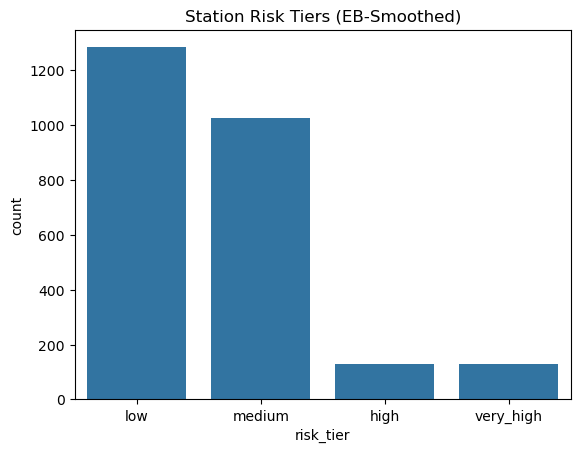

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=station, x="risk_tier", order=["low","medium","high","very_high"])
plt.title("Station Risk Tiers (EB-Smoothed)")
plt.show()


In [25]:
import folium

m = folium.Map(location=[40.75, -73.98], zoom_start=12)

color_map = {
    "low": "green",
    "medium": "orange",
    "high": "red",
    "very_high": "darkred"
}

for _, row in station.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=4,
        color=color_map[row["risk_tier"]],
        fill=True,
        fill_opacity=0.8,
        popup=f"{row['station_name']}<br>Risk tier: {row['risk_tier']}<br>R_eb={row['R_eb']:.4f}",
    ).add_to(m)

m.save("station_risk_tiers.html")


## **Station-Level Risk Summary**

#### 🟢 1. Low-Risk Areas
- Lower Manhattan
- West Side of Manhattan
- Central Manhattan interior
- Upper West Side + parts of Upper East Side  
- Brooklyn Heights
- Prospect Heights 

**Potential reasons**
- Strong bike infrastructure and calmer traffic  
- High rider volumes → lower hazard per trip  

#### 🟠 2. Medium-Risk Areas
- East Side
- Interior Harlem  
- Williamsburg / Greenpoint interior  
- Bushwick, Brooklyn  
- Astoria, Queens

**Potential reasons**
- Mixed-quality bike lanes  
- Moderate traffic speeds and turning conflicts  
- Moderate usage volumes → moderate per-trip hazard  


#### 🔴 3. High & Very High-Risk Areas
**Where**
- East Harlem & Washington Heights (east side)  
- Williamsburg & Greenpoint waterfront  
- Downtown Brooklyn near major arterials  
- Long Island City waterfront & bridge/tunnel approaches  
- Southwest Brooklyn (Sunset Park, Red Hook, Industry City, Bay Ridge) — largest hotspot  

**Why**
- Heavy or high-speed vehicle traffic (incl. truck routes)  
- Poor or missing bike infrastructure  
- Complex intersections and industrial street grids  
- Low CitiBike trip volumes → higher hazard per trip even from few crashes  

### **Interpretation and Implications**
- **High-risk stations** represent locations where the *expected crash severity per ride* is disproportionately large.  
  These are priority candidates for user warnings and insurer attention.

- **Low-risk stations** typically lie on protected corridors or physically separated bike routes, confirming that infrastructure quality is a key safety driver.

- **Empirical Bayes smoothing ensures stability**: risk scores reflect true underlying patterns, not noise from low-exposure stations.

### **Operational Opportunities**
- **User Safety Alerts:**  
  Flag high- and very-high-risk stations in the rental app, especially during peak times.

- **Insurance Product Design:**  
  Use station-level EB risk as a feature in expected-loss calculations or dynamic pricing models.

- **City-Level Advocacy:**  
  Present high-risk clusters to NYC DOT as evidence-driven targets for protected lane buildout, traffic calming, or intersection redesign.

### **Strategic Takeaway**
The risk map provides a **exposure-adjusted view of cyclist safety**, enabling CitiBike, insurers, and the City of New York to coordinate interventions that materially reduce cyclist injuries and improve rider confidence.

## Temporal risk

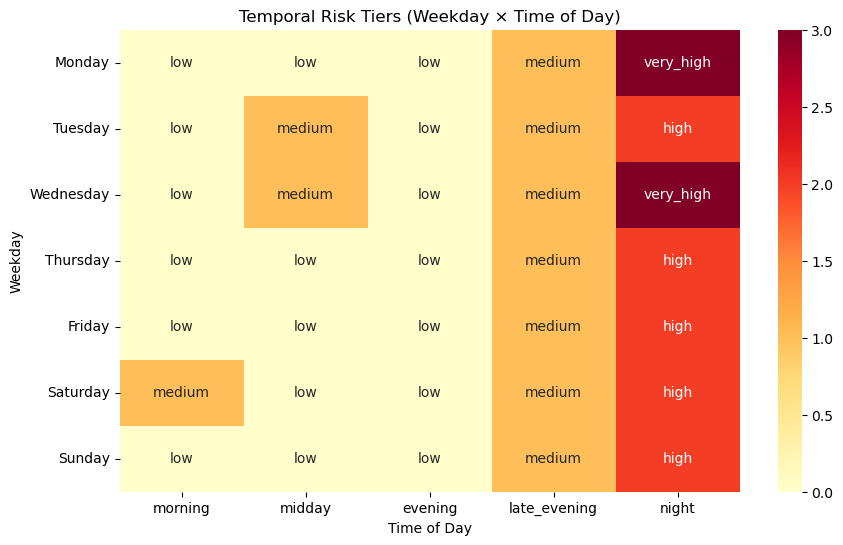

In [40]:
# Temporal risk: aggregate across all stations
temporal = (
    risk_panel
    .groupby(["weekday", "tod"], as_index=False)
    .agg({"H": "sum", "E": "sum"})
)

# Raw temporal risk
EPS = 1e-6
temporal["R_raw"] = temporal["H"] / (temporal["E"] + EPS)

# Global mean risk per trip
mu = risk_panel["H"].sum() / risk_panel["E"].sum()

# Credibility constant
C = 200.0

# Credibility weight
temporal["lambda"] = temporal["E"] / (temporal["E"] + C)

# EB-smoothed temporal risk
temporal["R_eb"] = temporal["lambda"] * temporal["R_raw"] + (1 - temporal["lambda"]) * mu

# Compute quantile cutoffs
q50, q80, q95 = temporal["R_eb"].quantile([0.50, 0.80, 0.95])

# Assign tier labels
def assign_temporal_tier(r):
    if r <= q50:
        return "low"
    elif r <= q80:
        return "medium"
    elif r <= q95:
        return "high"
    else:
        return "very_high"

temporal["risk_tier"] = temporal["R_eb"].apply(assign_temporal_tier)

temp_tier_pivot = temporal.pivot(index="weekday", columns="tod", values="risk_tier")
temp_tier_pivot = temp_tier_pivot.reindex(index=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
                                          columns=["morning", "midday", "evening", "late_evening", "night"])

plt.figure(figsize=(10, 6))
sns.heatmap(temp_tier_pivot.map(lambda x: {"low":0, "medium":1, "high":2, "very_high":3}[x]),
            cmap="YlOrRd",
            cbar=True,
            annot=temp_tier_pivot,
            fmt="")
plt.title("Temporal Risk Tiers (Weekday × Time of Day)")
plt.xlabel("Time of Day")
plt.ylabel("Weekday")
plt.show()


## **Interpretation of Temporal Risk Tiers**

- **Risk here is measured per trip**, not total crashes.  
  A time period with many trips but few severe crashes will have *lower per-trip risk* than a period with few trips but more severe crashes.

- **Commuting hours (morning and evening) do not show as high risk** because:
  - Exposure is very high → risk = H/E becomes smaller.
  - Visibility is good → fewer severe crashes.
  - Vehicle speeds are lower → lower injury severity.
  These factors produce *moderate* per-trip risk despite heavy usage.

- **Midday is the safest period** across all days:
  - optimal daylight,
  - moderate traffic speeds,
  - fewer turning conflicts.
  This results in consistently *low* per-trip risk.

- **Late evening and night show the highest per-trip risk**, often “high” or “very high”:
  - low visibility,
  - higher vehicle speeds,
  - more severe crashes,
  - lower cyclist exposure → less EB shrinkage.
  These amplify per-trip danger even if the number of crashes is not high.

- **Overall pattern**:  
  - **Low:** midday  
  - **Medium:** morning and early evening  
  - **High:** late evening  
  - **Very high:** nighttime  
  This aligns with well-established traffic-safety findings (visibility, speed, and safety-in-numbers effects).

### **Strategic Takeaway**
- **Nighttime riding is disproportionately dangerous per trip**, suggesting clear opportunities for targeted safety interventions (lighting, speed management, in-app warnings).
- **Commuting hours are busy but relatively safe per trip**, especially compared to night—highlighting the value of protected infrastructure and the safety-in-numbers effect.
- **Midday remains the optimal period for safe riding**, which can inform user guidance, insurance pricing models, and city-level planning for bike traffic flows.


## Station × Time-of-Day Risk

- Combining station-level and time-of-day information creates the most actionable risk metric in the entire analysis.
- This approach identifies stations that are generally safe but become high-risk at specific times (often late evening or night).
- It reveals temporal danger corridors—areas where risk spikes after dark due to visibility, speed, and nightlife traffic.
- EB smoothing applied separately within each time-of-day ensures stable, interpretable risk estimates even when exposure varies hugely across the day.
- The resulting product supports:
  - **user-facing warnings** that depend on both station and time,
  - **insurer expected-loss modeling** by capturing high-severity low-volume periods,
  - **city-level planning** targeted at nighttime hotspots and evening commuter conflict zones.
- This layer completes the spatial–temporal risk picture, allowing CitiBike to identify not only *where* risk is concentrated, but *when* it emerges.

### Station × Time-of-Day Risk Tiers

We classify each station–time-of-day cell into four risk tiers:

- **Low:** bottom 50% of stations for that time-of-day  
- **Medium:** 50–80%  
- **High:** 80–95%  
- **Very high:** top 5%

This reveals stations that are:

- safe during the day but dangerous at night,
- commuter-time hotspots,
- consistently high-risk across all times,
- or uniformly low-risk.

These tiers support user-facing warnings, insurer pricing models, and targeted infrastructure interventions.



In [42]:
import pandas as pd
import numpy as np

EPS = 1e-6
C = 200.0  # credibility constant

# ------------------------------------------------------------
# 1. Aggregate hazard (H) and exposure (E) by station × TOD
#    (sum over weekdays)
# ------------------------------------------------------------
station_tod = (
    risk_panel
    .groupby(["station_id", "tod"], as_index=False)
    .agg({"H": "sum", "E": "sum"})
)

# Add station metadata
station_tod = station_tod.merge(
    stations[["station_id", "station_name", "lat", "lon"]],
    on="station_id",
    how="left"
)

# Raw risk per station × TOD
station_tod["R_raw"] = station_tod["H"] / (station_tod["E"] + EPS)

# ------------------------------------------------------------
# 2. Compute TOD-specific global mean risk μ_tod
#    μ_tod = (Σ_j H_{j,tod}) / (Σ_j E_{j,tod})
# ------------------------------------------------------------
mu_tod_series = (
    station_tod
    .groupby("tod")
    .apply(lambda g: g["H"].sum() / (g["E"].sum() + EPS))
)

mu_tod = mu_tod_series.to_dict()  # map tod -> μ_tod

station_tod["mu_tod"] = station_tod["tod"].map(mu_tod)

# ------------------------------------------------------------
# 3. EB smoothing within each TOD:
#    λ_{j,tod} = E_{j,tod} / (E_{j,tod} + C)
#    R_eb_{j,tod} = λ R_raw + (1-λ) μ_tod
# ------------------------------------------------------------
station_tod["lambda"] = station_tod["E"] / (station_tod["E"] + C)
station_tod["R_eb"] = (
    station_tod["lambda"] * station_tod["R_raw"]
    + (1 - station_tod["lambda"]) * station_tod["mu_tod"]
)

# Optional: sort for inspection
station_tod = station_tod.sort_values(["tod", "R_eb"], ascending=[True, False]).reset_index(drop=True)

station_tod.head()


/var/folders/6c/gmnjxh5x1hn48qy93ptqpz580000gn/T/ipykernel_47049/2556450681.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["H"].sum() / (g["E"].sum() + EPS))


,station_id,tod,H,E,station_name,lat,lon,R_raw,mu_tod,lambda,R_eb
0,2908.02,evening,52.9,27.0,E 3 St & Cortelyou Rd,40.63828,-73.97650,1.959259,0.000761,0.118943,0.233710
1,2615.05,evening,39.0,29.0,Bay Ridge Pkwy & 5 Ave,40.62967,-74.02275,1.344828,0.000761,0.126638,0.170970
2,2261.04,evening,31.2,6.0,5 Ave & 88 St,40.62021,-74.02717,5.199999,0.000761,0.029126,0.152195
3,3056.07,evening,34.6,58.0,37 St & 13 Ave,40.64166,-73.98505,0.596552,0.000761,0.224806,0.134699
4,2488.09,evening,25.2,25.0,6 Ave & 78 St,40.62569,-74.02119,1.008000,0.000761,0.111111,0.112677


In [43]:
# Determine tier cutoffs within each time-of-day
tiers = {}

for tod in station_tod["tod"].unique():
    subset = station_tod[station_tod["tod"] == tod]
    q50, q80, q95 = subset["R_eb"].quantile([0.50, 0.80, 0.95])
    tiers[tod] = (q50, q80, q95)

def assign_station_tod_tier(row):
    q50, q80, q95 = tiers[row["tod"]]
    r = row["R_eb"]
    if r <= q50: return "low"
    elif r <= q80: return "medium"
    elif r <= q95: return "high"
    else: return "very_high"

station_tod["risk_tier"] = station_tod.apply(assign_station_tod_tier, axis=1)


In [49]:
import folium
import numpy as np

# Make sure station_tod has: station_id, station_name, lat, lon, tod, R_eb, risk_tier

# Colors for high-risk tiers
tier_color = {
    "high": "red",
    "very_high": "darkred"
}

# Order of time-of-day layers
tod_order = ["morning", "midday", "evening", "late_evening", "night"]

# -------------------------------------------------------------------
# 1. Center the map roughly on the average station location
# -------------------------------------------------------------------
center_lat = station_tod["lat"].mean()
center_lon = station_tod["lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# -------------------------------------------------------------------
# 2. Create one FeatureGroup per time-of-day with only high/very_high
# -------------------------------------------------------------------
for tod_label in tod_order:
    # Subset for this TOD and only high/very_high risk
    subset = station_tod[
        (station_tod["tod"] == tod_label) &
        (station_tod["risk_tier"].isin(["high", "very_high"]))
    ]
    
    # Skip empty layers (e.g., if no stations are high at midday)
    if subset.empty:
        continue
    
    fg = folium.FeatureGroup(name=tod_label, show=(tod_label == "night"))  # e.g. show night by default

    for _, row in subset.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=5,
            color=tier_color[row["risk_tier"]],
            fill=True,
            fill_opacity=0.9,
            popup=(
                f"{row['station_name']}<br>"
                f"TOD: {tod_label}<br>"
                f"R_eb={row['R_eb']:.4f}<br>"
                f"Tier={row['risk_tier']}"
            ),
        ).add_to(fg)
    
    fg.add_to(m)

# -------------------------------------------------------------------
# 3. Add layer control to toggle time-of-day layers
# -------------------------------------------------------------------
folium.LayerControl(collapsed=False).add_to(m)

m.save("station_risk_tiers_by_tod.html")


## **How to Use the Time-of-Day High-Risk Station Map**

### **(i) User-Facing Warnings**
- Identify stations that are **high or very-high risk only at specific times** (e.g., night, evening).
- Trigger **contextual in-app safety alerts** when a user rents from one of these stations during its risky time window.
- Avoids over-alerting: stations that are safe during the day but risky at night only generate warnings when relevant.
- Helps riders make safer decisions by highlighting **when and where** risk is elevated.

### **(ii) Working with NYC DOT on Infrastructure Improvements**
- Highlight **nighttime-only hotspots** that may indicate poor lighting, high vehicle speeds, or nightlife-driven traffic.
- Identify **evening commuter hotspots** that reveal missing protected lanes or risky intersection layouts.
- Provide DOT with **time-specific evidence** to guide targeted interventions, such as:
  - improved lighting,
  - protected bike lanes,
  - traffic-calming measures,
  - redesigned intersections.
- Enables **cost-effective, data-driven planning** by focusing improvements on the exact locations and times where risk is elevated.

### **Strategic Takeaway**
The map shows not only *where* stations are risky, but *when* they become dangerous—supporting real-time user safety and long-term city-level infrastructure investment.

## **How an Insurer Could Use the Station × Time-of-Day Risk Measure**

### **1. Pricing per-trip or per-minute insurance**
- The EB-smoothed risk measure provides an estimate of the **expected crash severity per trip** from each station at each time-of-day.
- Insurers can translate this into a **time- and location-adjusted premium**, giving:
  - lower prices for midday or low-risk stations,
  - higher prices for nighttime trips or stations with recurrent severe crashes.
- This enables **fair, risk-based pricing** while keeping premiums affordable for most riders.

---

### **2. Identifying high-severity, low-frequency risk pockets**
- Some stations show **low risk during the day but very high risk at night** due to severe crashes in low-exposure conditions.
- These “nighttime danger pockets” are invisible in aggregate crash counts.
- Insurers can use this to:
  - apply **surge risk adjustments** at specific times,
  - cap liability during high-risk windows,
  - or incentivize safer riding times.

---

### **3. Portfolio-level expected loss modeling**
- By aggregating the risk measure over all expected trips (exposure), insurers can compute:
  - **expected claims cost per station, per hour, per month**, and
  - overall **portfolio loss ratios**.
- This is directly compatible with actuarial tools (credibility models, GLMs, frequency–severity decomposition).

---

### **4. Risk mitigation and operational guidance**
- High-risk station–time combinations (e.g., “Station 312 at night”) guide insurers to work with CitiBike to:
  - promote rider education,
  - issue in-app warnings,
  - offer discounts for safer time windows,
  - or recommend targeted infrastructure improvements.

---

### **5. Dynamic product design**
- Insurers can create innovative products such as:
  - **per-ride micro-insurance** with price tied to real-time station + time-of-day risk,
  - **membership insurance** that adjusts premiums based on a rider’s typical travel pattern,
  - **seasonal or nighttime safety add-ons** for high-risk users.
- This aligns with global trends in mobility insurance (e.g., Lime–Allianz).

---

### **Strategic Takeaway**
The station × time-of-day EB risk measure provides insurers with a **granular, actuarially credible assessment of expected severity per trip**, enabling fair pricing, better underwriting decisions, and collaborative risk mitigation with CitiBike and the City of New York.


---

---

# Risk Analysis: CitiBike × NYPD Collision Data

We combine CitiBike trip data with NYPD collision records to quantify safety risks around CitiBike stations. Our goals are to  
1. **warn users** when renting from high-risk stations;  
2. **show how the two datasets jointly inform insurers** about expected loss;  
3. **identify hazardous areas** where CitiBike can advocate for safety improvements.

---

## Conceptual Definition of the Risk Measure

We measure **risk** as the *expected crash severity per CitiBike trip* from a given station and in a given time window.

For a station $j$ and time bucket $b$ (e.g., weekday or time-of-day), we define:

- **Hazard** (crash severity in the vicinity of the station and time window)
  $$
  H_{j,b} = \sum_{i \in (j,b)} S_i,
  $$
  where $S_i$ is the severity score of crash $i$.

- **Exposure** (how many CitiBike trips are “at risk” in that window)
  $$
  E_{j,b},
  $$
  defined as the number of CitiBike departures from station $j$ in time bucket $b$.

The **raw risk** is then
$$
R_{j,b} = \frac{H_{j,b}}{E_{j,b} + \epsilon},
$$
where $\epsilon$ is a small constant to avoid division by zero.

Because exposure varies widely across stations and times, the raw ratio $R_{j,b}$ can be extremely noisy, especially when $E_{j,b}$ is small and a single crash occurs. To stabilize these estimates, we apply **Empirical Bayes (EB) smoothing**:

$$
R_{j,b}^{\text{EB}} = \lambda_{j,b} R_{j,b} + (1 - \lambda_{j,b}) \mu,
$$

where:
- $\mu$ is a global mean risk (or a time-of-day specific mean),
- $\lambda_{j,b} = \frac{E_{j,b}}{E_{j,b} + C}$ is the **credibility weight**,  
- $C>0$ is a credibility constant.

Interpretation:
- Large $E_{j,b}$ (many trips) $\Rightarrow \lambda_{j,b} \approx 1$ and $R_{j,b}^{\text{EB}} \approx R_{j,b}$ (we trust the data).
- Small $E_{j,b}$ (few trips) $\Rightarrow \lambda_{j,b} \approx 0$ and $R_{j,b}^{\text{EB}} \approx \mu$ (we shrink towards the overall mean).

This gives us a **stable, interpretable measure** of expected crash severity per trip that can be aggregated:

- **Station-level risk** by summing over time buckets,
- **Temporal risk** by aggregating across stations,
- **Station × time-of-day risk** as the most granular product.

In the following, we use this framework consistently at all levels of analysis.


In [1]:
# Imports & Helper Functions
import pandas as pd
import numpy as np
import duckdb
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

plt.style.use("seaborn-v0_8")
sns.set_context("notebook")

# Constants
DATA_PATH = "../data/processed/citibike/*/*/data.parquet"
COLLISION_PATH = "../data/processed/cleaned_collision_data.csv"

EPS = 1e-6
EARTH_RADIUS_M = 6_371_000
MAX_DIST_M = 300  # meters: max distance station-crash
C = 200.0         # EB credibility constant

def time_of_day(hour: int) -> str:
    if 5 <= hour < 10:
        return "morning"
    elif 10 <= hour < 16:
        return "midday"
    elif 16 <= hour < 20:
        return "evening"
    elif 20 <= hour < 24:
        return "late_evening"
        # treat 0–5 as night
    else:
        return "night"

def eb_smooth(H, E, mu, C=C):
    """
    Empirical Bayes smoothing:
      R_raw = H / (E + EPS)
      lambda = E / (E + C)
      R_eb  = lambda * R_raw + (1 - lambda) * mu
    Returns (R_raw, R_eb, lambda).
    """
    lam = E / (E + C)
    R_raw = H / (E + EPS)
    R_eb = lam * R_raw + (1 - lam) * mu
    return R_raw, R_eb, lam


## Crash Severity

The **hazard** component of the risk measure is built from a crash-level severity score $S_i$ that satisfies:

1. Cyclist-involved crashes matter much more than other crashes.  
2. Injuries make a crash substantially more severe than property-damage-only events.  
3. Fatalities are treated as much more severe than injuries.

Let:
- $\text{injured}_i$ = number of persons injured in crash $i$  
- $\text{killed}_i$ = number of persons killed  
- $\text{cyclist}_i \in \{0,1\}$ = 1 if a cyclist was involved  

We define

$$
S_i
=
\Bigl( 1 + W_I \cdot \text{injured}_i + W_K \cdot \text{killed}_i \Bigr)
\cdot
\Bigl( \alpha + (1 - \alpha)\,\text{cyclist}_i \Bigr),
$$

where:
- $W_I > 0$ increases severity with injuries,  
- $W_K > W_I$ increases severity even more with fatalities,  
- $\alpha \in (0,1)$ down-weights crashes without cyclists.

In our baseline:
- $W_I = 5$,  
- $W_K = 20$,  
- $\alpha = 0.1$,

so that:
- a cyclist crash is roughly 10× a comparable non-cyclist crash,  
- injuries and fatalities are strongly up-weighted.

This yields a hazard measure that:
- does **not ignore non-cyclist crashes**, capturing general traffic risk,
- but **strongly emphasizes cyclist-involved and severe crashes**, which is key for CitiBike users and insurers.


In [2]:
# Load Collision Data and Compute Severity
collision = pd.read_csv(COLLISION_PATH, parse_dates=["CRASH DATETIME"])
collision = collision.dropna(subset=["LATITUDE", "LONGITUDE", "CRASH DATETIME"])

collision["CYCLIST_INVOLVED"] = collision["CYCLIST_INVOLVED"].fillna(0).astype(int)
collision["NUMBER OF PERSONS INJURED"] = collision["NUMBER OF PERSONS INJURED"].fillna(0)
collision["NUMBER OF PERSONS KILLED"] = collision["NUMBER OF PERSONS KILLED"].fillna(0)

collision["weekday"] = collision["CRASH DATETIME"].dt.day_name()
collision["hour"] = collision["CRASH DATETIME"].dt.hour
collision["tod"] = collision["hour"].apply(time_of_day)

W_I = 5.0
W_K = 20.0
alpha = 0.1

base_severity = (
    1
    + W_I * collision["NUMBER OF PERSONS INJURED"]
    + W_K * collision["NUMBER OF PERSONS KILLED"]
)

collision["severity"] = (
    collision["CYCLIST_INVOLVED"] * base_severity
    + alpha * (1 - collision["CYCLIST_INVOLVED"]) * base_severity
)


In [3]:
# Build Station Table
con = duckdb.connect()

stations = con.execute(
    """
    WITH trips AS (
        SELECT
            start_station_id, start_station_name, start_lat, start_lng,
            end_station_id,   end_station_name,   end_lat,   end_lng
        FROM read_parquet($data_path)
    ),
    stations_union AS (
        SELECT
            start_station_id AS station_id,
            start_station_name AS station_name,
            start_lat AS lat,
            start_lng AS lon
        FROM trips
        WHERE start_station_id IS NOT NULL

        UNION

        SELECT
            end_station_id AS station_id,
            end_station_name AS station_name,
            end_lat AS lat,
            end_lng AS lon
        FROM trips
        WHERE end_station_id IS NOT NULL
    )
    SELECT DISTINCT
        CAST(station_id AS VARCHAR) AS station_id,
        station_name,
        ROUND(lat::DOUBLE, 5) AS lat,
        ROUND(lon::DOUBLE, 5) AS lon
    FROM stations_union
    ORDER BY station_id
    """,
    {"data_path": DATA_PATH},
).df()

stations = stations.dropna(subset=["lat", "lon"])


In [4]:
# Match Collisions → Stations (≤300 m)
station_coords_rad = np.deg2rad(stations[["lat", "lon"]].values)
tree = BallTree(station_coords_rad, metric="haversine")

collision_coords_rad = np.deg2rad(collision[["LATITUDE", "LONGITUDE"]].values)
dist_rad, idx = tree.query(collision_coords_rad, k=1)
dist_m = dist_rad.flatten() * EARTH_RADIUS_M

nearest_station_ids = stations.iloc[idx.flatten()]["station_id"].values
collision["station_id"] = np.where(dist_m <= MAX_DIST_M, nearest_station_ids, np.nan)
collision = collision.dropna(subset=["station_id"])
collision["station_id"] = collision["station_id"].astype(str)


In [5]:
# Build Risk Panel: station × weekday × time of day
# Hazard: sum of severity per station × weekday × time of day
hazard = (
    collision.groupby(["station_id", "weekday", "tod"], as_index=False)["severity"]
    .sum()
    .rename(columns={"severity": "H"})
)

# Exposure: number of departures per station × weekday × time of day
exposure = con.execute(
    """
    WITH trips AS (
        SELECT
            CAST(start_station_id AS VARCHAR) AS station_id,
            started_at
        FROM read_parquet($data_path)
        WHERE start_station_id IS NOT NULL
    ),
    trips_buckets AS (
        SELECT
            station_id,
            started_at,
            strftime(started_at, '%A') AS weekday,
            CASE
                WHEN EXTRACT(hour FROM started_at) BETWEEN 5 AND 9 THEN 'morning'
                WHEN EXTRACT(hour FROM started_at) BETWEEN 10 AND 15 THEN 'midday'
                WHEN EXTRACT(hour FROM started_at) BETWEEN 16 AND 19 THEN 'evening'
                WHEN EXTRACT(hour FROM started_at) BETWEEN 20 AND 23 THEN 'late_evening'
                ELSE 'night'
            END AS tod
        FROM trips
    )
    SELECT
        station_id,
        weekday,
        tod,
        COUNT(*) AS E
    FROM trips_buckets
    GROUP BY station_id, weekday, tod
    """,
    {"data_path": DATA_PATH},
).df()

risk_panel = hazard.merge(exposure, on=["station_id", "weekday", "tod"], how="left")
risk_panel["E"] = risk_panel["E"].fillna(0)


## Station-Level Risk

At the **station level**, we aggregate hazard and exposure over all weekdays and times:

- Station-level hazard:
  $$
  H_j = \sum_b H_{j,b}
  $$
- Station-level exposure:
  $$
  E_j = \sum_b E_{j,b}
  $$

The raw station-level risk is:
$$
R_j = \frac{H_j}{E_j + \epsilon}.
$$

We apply Empirical Bayes smoothing with a **single global mean** $\mu$:
$$
R_j^{\text{EB}} = \lambda_j R_j + (1 - \lambda_j) \mu,
\quad
\lambda_j = \frac{E_j}{E_j + C},
$$

where $C$ is the credibility constant. This yields a **stable station-level risk index** that can be used to identify:

- systematically high-risk stations,
- safe corridor stations,
- and candidates for infrastructure improvements.


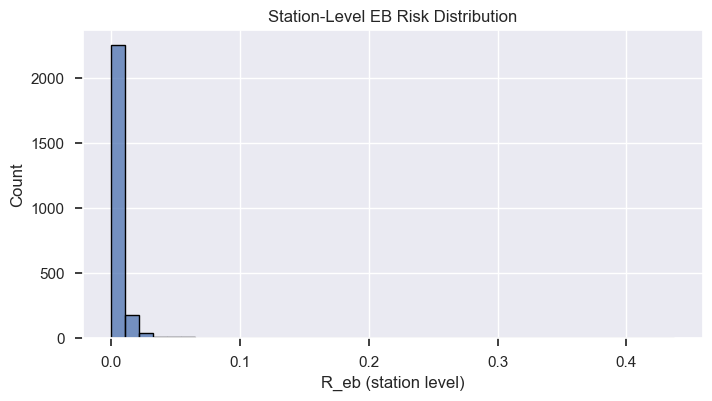

In [6]:
# Compute station-level EB risk
# Aggregate to station level
station_agg = (
    risk_panel.groupby("station_id", as_index=False)[["H", "E"]]
    .sum()
)

# Global mean risk
mu_global = station_agg["H"].sum() / (station_agg["E"].sum() + EPS)

# EB smoothing
station_agg["R_raw"], station_agg["R_eb"], station_agg["lambda"] = eb_smooth(
    station_agg["H"], station_agg["E"], mu_global, C=C
)

# Attach metadata
station_agg = station_agg.merge(stations, on="station_id", how="left")

# Plot distribution
plt.figure(figsize=(8,4))
sns.histplot(station_agg["R_eb"], bins=40)
plt.title("Station-Level EB Risk Distribution")
plt.xlabel("R_eb (station level)")
plt.show()


In [7]:
# Quantile-based tiers: low / medium / high / very_high
q50, q90, q95 = station_agg["R_eb"].quantile([0.5, 0.9, 0.95])

def station_tier(r):
    if r <= q50: return "low"
    elif r <= q90: return "medium"
    elif r <= q95: return "high"
    else: return "very_high"

station_agg["risk_tier"] = station_agg["R_eb"].apply(station_tier)

top10_stations = station_agg.sort_values("R_eb", ascending=False).head(10)
bottom10_stations = station_agg.sort_values("R_eb", ascending=True).head(10)

top10_stations[["station_name", "H", "E", "R_eb", "risk_tier"]], \
bottom10_stations[["station_name", "H", "E", "R_eb", "risk_tier"]]


(              station_name      H      E      R_eb  risk_tier
 1            5 Ave & 88 St   93.3   14.0  0.437234  very_high
 7            6 Ave & 78 St  105.3  100.0  0.351894  very_high
 59          37 St & 13 Ave  108.4  164.0  0.298539  very_high
 13  Bay Ridge Pkwy & 5 Ave   95.1  120.0  0.298026  very_high
 35   E 3 St & Cortelyou Rd   69.8   78.0  0.252044  very_high
 4            84 St & 3 Ave   43.3    3.0  0.214621  very_high
 21           68 St & 4 Ave   66.5  118.0  0.209963  very_high
 9      83 St & Narrows Ave   41.5   47.0  0.169102  very_high
 16           4 Ave & 72 St   49.3  119.0  0.155386  very_high
 5            4 Ave & 81 St   34.8   36.0  0.148594  very_high,
                   station_name    H         E      R_eb risk_tier
 968   Greenwich St & Hubert St  1.0   27768.0  0.000045       low
 1076   Mercer St & Bleecker St  4.4   88427.0  0.000053       low
 1481          10 Ave & W 28 St  7.2  134442.0  0.000055       low
 920          Berry St & N 8 St  2.4  

In [10]:
m = folium.Map(location=[40.75, -73.98], zoom_start=12)

color_map = {
    "low": "green",
    "medium": "orange",
    "high": "red",
    "very_high": "darkred"
}

for _, row in station_agg.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=4,
        color=color_map[row["risk_tier"]],
        fill=True,
        fill_opacity=0.8,
        popup=f"{row['station_name']}<br>Risk tier: {row['risk_tier']}<br>R_eb={row['R_eb']:.4f}",
    ).add_to(m)

m.save("station_risk_tiers.html")

### Station-Level Risk: Interpretation, Implications, Opportunities, Strategy

**Interpretation**
- Most stations have very low EB risk, indicating that CitiBike trips are generally safe per ride.
- A small set of stations show much higher per-trip risk, driven by a combination of:
  - recurrent cyclist-involved crashes,
  - injuries or fatalities,
  - relatively low exposure compared to their hazard.

**Implications**
- CitiBike can identify *which* stations are disproportionately risky per trip.
- These stations are natural candidates for closer review, signage, or routing suggestions.
- Low-risk stations serve as benchmarks for what “good” infrastructure and traffic environments look like.

**Operational Opportunities**
- **User Safety Alerts:**  
  Flag high- and very-high-risk stations in the rental app, especially during peak times.
- **Insurance Product Design:**  
  Use station-level EB risk as a feature in expected-loss calculations or dynamic pricing models.
- **City-Level Advocacy:**  
  Present high-risk clusters to NYC DOT as evidence-driven targets for protected lane buildout, traffic calming, or intersection redesign.

**Strategic Takeaway**
The risk map provides a **exposure-adjusted view of cyclist safety**, enabling CitiBike, insurers, and the City of New York to coordinate interventions that materially reduce cyclist injuries and improve rider confidence.

## Time-of-Day Risk

We now examine **when** riding is most dangerous, abstracting from specific stations.

We aggregate hazard and exposure across all stations:

- Hazard in time bucket $b$ (e.g. morning, midday, evening, late_evening, night):
  $$
  H_b = \sum_j H_{j,b}
  $$
- Exposure:
  $$
  E_b = \sum_j E_{j,b}
  $$

Raw temporal risk:
$$
R_b = \frac{H_b}{E_b + \epsilon}.
$$

We again apply EB smoothing (here with a global $\mu$) to stabilize estimates, especially for low-exposure time windows at night.


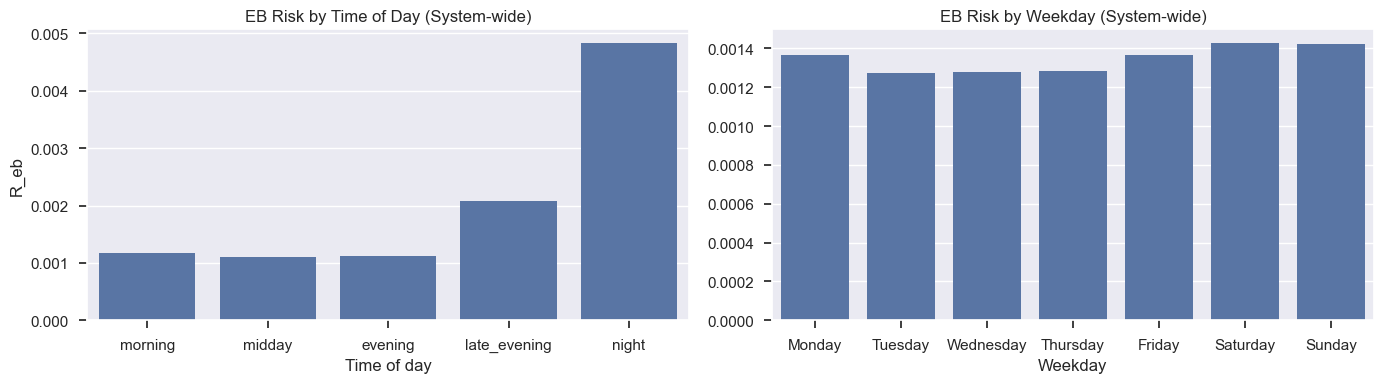

In [12]:
# ---- Temporal risk by time of day ----
temporal_tod = (
    risk_panel.groupby("tod", as_index=False)[["H", "E"]]
    .sum()
)

mu_tod = temporal_tod["H"].sum() / (temporal_tod["E"].sum() + EPS)
temporal_tod["R_raw"], temporal_tod["R_eb"], temporal_tod["lambda"] = eb_smooth(
    temporal_tod["H"], temporal_tod["E"], mu_tod, C=C
)

tod_order = ["morning", "midday", "evening", "late_evening", "night"]

# ---- Temporal risk by weekday ----
temporal_wd = (
    risk_panel.groupby("weekday", as_index=False)[["H", "E"]]
    .sum()
)

mu_wd = temporal_wd["H"].sum() / (temporal_wd["E"].sum() + EPS)
temporal_wd["R_raw"], temporal_wd["R_eb"], temporal_wd["lambda"] = eb_smooth(
    temporal_wd["H"], temporal_wd["E"], mu_wd, C=C
)

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# ---- Combined 1×2 plot ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

# Left: Time of day
sns.barplot(
    data=temporal_tod, x="tod", y="R_eb",
    order=tod_order, ax=axes[0]
)
axes[0].set_title("EB Risk by Time of Day (System-wide)")
axes[0].set_xlabel("Time of day")
axes[0].set_ylabel("R_eb")

# Right: Weekday
sns.barplot(
    data=temporal_wd, x="weekday", y="R_eb",
    order=weekday_order, ax=axes[1]
)
axes[1].set_title("EB Risk by Weekday (System-wide)")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("")  # sharey handles the label

plt.tight_layout()
plt.show()


### Time-of-Day & Weekday Risk: Interpretation, Implications, Opportunities, Strategy

**Interpretation**

- **Time-of-day patterns dominate weekday patterns.**
  - Morning, midday, and evening have similar and relatively low risk levels.
  - **Late evening** risk is roughly **2×** midday risk.
  - **Night** (20:00–05:00) is the clear outlier with **4–5×** the risk of daytime periods.

- **Weekday differences are minimal.**
  - Monday–Friday risk levels are nearly identical.
  - Weekend days (Saturday, Sunday) show no meaningful deviation.
  - This indicates that crash severity per trip is **not meaningfully driven by weekday traffic cycles**.

Overall, the temporal risk landscape is shaped almost entirely by **time of day**, not the day of the week.

### Implications

- Riders’ **time-of-day choices** matter far more for per-trip safety than the calendar day.
- Safety interventions focused on weekday commuting would **miss the true risk peak**, which occurs late at night.
- Weekend service or special events do not materially alter average per-trip risk.

### Operational Opportunities

- **Time-aware safety warnings**:
  - Push notifications or app warnings triggered between **20:00–05:00**, regardless of weekday.
  - Encourage visibility (lights/reflectors), slower speeds, or alternative routes at night.

- **Resource prioritization**:
  - Reallocate community outreach, education, and safety messaging to **evening and nighttime riders**, not weekday commuters.
  - Staff nighttime maintenance and station checks to address risks associated with lighting or station placement.

- **Data-informed scheduling**:
  - If CitiBike or insurers consider time-based pricing or incentives, the data strongly suggests:
    - **discounts** during low-risk periods,
    - **surcharges or enhanced coverage** during nighttime.

### Strategic Takeaway

- The system-wide risk pattern is **not “commuter-driven”** but **“visibility- and severity-driven.”**
- Nighttime is the period where CitiBike, the City of New York, and insurer partners can achieve the **largest safety improvements per dollar spent**.
- Any long-term strategy—insurance pricing, infrastructure improvements, rider education—should treat **nighttime safety as a primary strategic priority**, while weekday variation can be safely deprioritized.


## Station × Time-of-Day Risk

The most granular view combines **where** and **when**:

For each station $j$ and time-of-day $t$ (aggregating over weekdays), we compute:

- Station–time hazard:
  $$
  H_{j,t} = \sum_{b \in t} H_{j,b}
  $$
- Station–time exposure:
  $$
  E_{j,t} = \sum_{b \in t} E_{j,b}
  $$

Raw station–time risk:
$$
R_{j,t} = \frac{H_{j,t}}{E_{j,t} + \epsilon}.
$$

We smooth **within each time-of-day** using a time-specific mean $\mu_t$:

$$
R_{j,t}^{\text{EB}} = \lambda_{j,t} R_{j,t} + (1 - \lambda_{j,t}) \mu_t,
\quad
\lambda_{j,t} = \frac{E_{j,t}}{E_{j,t} + C},
$$

where
$$
\mu_t = \frac{\sum_j H_{j,t}}{\sum_j E_{j,t}}.
$$

This yields a stable station × time-of-day risk measure that reveals, for example:
- stations that are essentially safe during the day but dangerous at night,  
- stations that are consistently high-risk at all times,  
- and temporal “danger pockets” that are invisible in station-only or time-only analyses.


In [13]:
station_tod = (
    risk_panel.groupby(["station_id", "tod"], as_index=False)[["H", "E"]]
    .sum()
)

# Time-of-day specific mean risk
mu_by_tod = (
    station_tod.groupby("tod")
    .apply(lambda g: g["H"].sum() / (g["E"].sum() + EPS))
    .to_dict()
)

station_tod["mu_tod"] = station_tod["tod"].map(mu_by_tod)
station_tod["R_raw"], station_tod["R_eb"], station_tod["lambda"] = eb_smooth(
    station_tod["H"], station_tod["E"], station_tod["mu_tod"], C=C
)

station_tod = station_tod.merge(stations, on="station_id", how="left")


/var/folders/6c/gmnjxh5x1hn48qy93ptqpz580000gn/T/ipykernel_51955/2144631366.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["H"].sum() / (g["E"].sum() + EPS))


In [14]:
# Risk tiers within each time-of-day
tiers_tod = {}
for tod in station_tod["tod"].unique():
    subset = station_tod[station_tod["tod"] == tod]
    q50, q80, q95 = subset["R_eb"].quantile([0.5, 0.8, 0.95])
    tiers_tod[tod] = (q50, q80, q95)

def assign_tod_tier(row):
    q50, q80, q95 = tiers_tod[row["tod"]]
    r = row["R_eb"]
    if r <= q50: return "low"
    elif r <= q80: return "medium"
    elif r <= q95: return "high"
    else: return "very_high"

station_tod["risk_tier"] = station_tod.apply(assign_tod_tier, axis=1)

# Single folium map with one layer per TOD, showing only high/very_high
tier_color = {"high": "red", "very_high": "darkred"}
tod_order = ["morning", "midday", "evening", "late_evening", "night"]

center_lat = station_tod["lat"].mean()
center_lon = station_tod["lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for tod_label in tod_order:
    subset = station_tod[
        (station_tod["tod"] == tod_label)
        & (station_tod["risk_tier"].isin(["high", "very_high"]))
    ]
    if subset.empty:
        continue
    fg = folium.FeatureGroup(name=tod_label, show=(tod_label == "night"))
    for _, row in subset.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=5,
            color=tier_color[row["risk_tier"]],
            fill=True,
            fill_opacity=0.9,
            popup=(
                f"{row['station_name']}<br>"
                f"TOD: {tod_label}<br>"
                f"R_eb={row['R_eb']:.4f}<br>"
                f"Tier={row['risk_tier']}"
            ),
        ).add_to(fg)
    fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("station_risk_tiers_by_tod.html")


### Station × Time-of-Day Risk: Interpretation, Implications, Opportunities, Strategy

**Interpretation**
- Many stations are **low risk during midday** but become **high or very high risk at night**, especially those near high-speed arterials, nightlife areas, or poorly lit intersections.
- Some stations exhibit **evening-specific risk spikes**, reflecting commuting flows and turning movements at busy junctions.
- A small subset of stations remain **consistently high-risk across all times of day**, pointing to structural design or traffic problems.

**Implications**
- Risk is both **spatial and temporal**: focusing only on station-level averages or system-wide time-of-day averages would miss key patterns.
- The station × time-of-day risk surface pinpoints exactly *where and when* risk is elevated.

**Operational Opportunities**
- Time- and location-specific user warnings:
  - e.g., “This station has elevated cyclist-injury risk at night. Please ride with extra caution.”
- Targeted collaboration with NYC DOT:
  - night-time hotspots → lighting, speed reduction, enforcement;
  - evening commuter hotspots → protected lanes, intersection redesign.
- Insurer integration:
  - use station × TOD risk as a feature in expected-loss models and dynamic pricing,
  - design per-ride products that adjust premiums based on real-time station and time-of-day risk.

**Strategic Takeaway**
- The station × time-of-day EB risk measure is the most actionable output of this analysis.
- It links **real-time user safety**, **insurance pricing**, and **city-level infrastructure planning** in a unified, data-driven framework.
- CitiBike can use it to both **improve rider safety now** (through warnings and communication) and **advocate for long-term safety investments** with insurers and NYC DOT.


## How an Insurer Can Use the Station × Time-of-Day Risk Measure

**Interpretation for insurers**
- $R_{j,t}^{\text{EB}}$ is an estimate of *expected crash severity per trip* from station $j$ at time-of-day $t$, smoothed in an actuarially credible way.
- Multiplying this by projected exposure (number of covered trips) yields **expected claims cost** by segment (station, time-of-day, or portfolio).

**Use cases**
- **Risk-based pricing** of per-ride or membership insurance:
  - lower rates for low-risk stations/times (e.g., midday),
  - higher rates for high-risk nighttime or hotspot stations.
- **Identification of high-severity, low-frequency pockets**:
  - stations that look benign in aggregate but exhibit very high nighttime risk.
- **Portfolio management**:
  - monitor expected loss contributions by station cluster or time-of-day,
  - design reinsurance or internal limits for high-risk segments.
- **Collaborative risk mitigation**:
  - co-fund infrastructure improvements at persistent hotspots,
  - sponsor rider safety programs targeted at high-risk times and locations.

**Strategic takeaway for insurers**
- The risk measure provides a granular, interpretable input into modern actuarial modeling.
- It supports **fair pricing** (users pay more where expected loss is higher) and **proactive risk reduction** (lower expected loss over time through targeted interventions).
